# Project report

### Topic 6 Optimization for Machine Learning

#### Hard Margin

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import cvxpy
from cvxpy import *

In [14]:
# Dimension is 2
d = 2
# Number of points in each class
m = 100
n = 100

x_center = [1,1]  
y_center = [3,1] 
np.random.seed(8)

[[0.8734294  0.96854066]
 [0.86919454 0.53085569]]


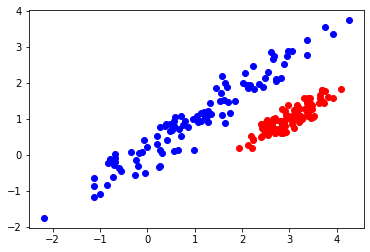

In [15]:
#2x2 array of random numbers
orientation_x = np.random.rand(2,2) 
print(orientation_x)
orientation_y = np.random.rand(2,2)

# Generate points
rx = np.clip(np.random.randn(m,d),-2,2)
ry = np.clip(np.random.randn(n,d),-2,2)
x = x_center + np.dot(rx,orientation_x)
y = y_center + np.dot(ry,orientation_y)

plt.scatter(x[:,0],x[:,1],color='blue')
plt.scatter(y[:,0],y[:,1],color='red')

c:\users\xbfan3\appdata\local\programs\python\python39\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 201 times so far.

  warnings.warn(msg, UserWarning)
c:\users\xbfan3\appdata\local\programs\python\python39\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 202 times

Problem Status: optimal
[[-2.65837297]
 [ 2.39731919]]
3.337079252473717


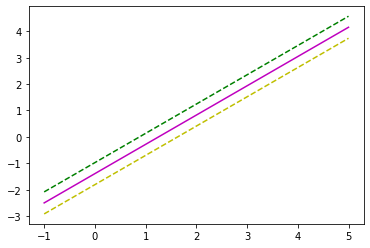

In [10]:
a = Variable((d,1))
b = Variable()
obj = Minimize((norm(a,2)))

x_constraints = [a.T * x[i] + b >= 1  for i in range(m)]
y_constraints = [a.T * y[i] + b <= -1 for i in range(n)]

constraints = x_constraints +  y_constraints  

prob = Problem(obj, constraints)

prob.solve()
print("Problem Status: %s"%prob.status)

p = a.value
q = b.value
print(p)
print(q)

m = (-q - p[0]*x)/p[1]
x = np.linspace(-1, 5, 20)
plt.plot(x, (-q - (p[0]*x))/p[1] , 'm')
plt.plot(x, (-q - (p[0]*x)+1)/p[1] ,'g--')
plt.plot(x, (-q - (p[0]*x)-1)/p[1] , 'y--')
plt.show()

#### Soft Margin with kernel trick

In [17]:
from numpy import linalg
import cvxopt
import cvxopt.solvers

In [18]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [19]:
class SVM(object):
    
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])
        
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)
        
        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print('{0} support vectors out of {1} points'.format(len(self.a), n_samples))

        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
    
    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
        return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

     pcost       dcost       gap    pres   dres
 0: -1.7814e+01 -3.0700e+01  1e+03  2e+01  6e-15
 1: -3.2867e+00 -2.7953e+01  6e+01  1e+00  6e-15
 2: -1.6487e+00 -9.9745e+00  1e+01  8e-02  1e-15
 3: -1.7089e+00 -3.1156e+00  2e+00  1e-02  2e-15
 4: -1.9412e+00 -2.3957e+00  5e-01  3e-03  1e-15
 5: -2.0073e+00 -2.2413e+00  2e-01  1e-03  8e-16
 6: -2.0596e+00 -2.1485e+00  9e-02  3e-04  8e-16
 7: -2.0818e+00 -2.1058e+00  2e-02  3e-05  9e-16
 8: -2.0913e+00 -2.0935e+00  2e-03  2e-06  1e-15
 9: -2.0922e+00 -2.0924e+00  1e-04  8e-08  1e-15
10: -2.0923e+00 -2.0923e+00  2e-06  8e-10  1e-15
Optimal solution found.
29 support vectors out of 180 points


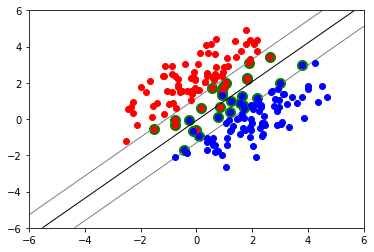

     pcost       dcost       gap    pres   dres
 0: -1.8165e+01 -3.5953e+01  6e+02  3e+01  2e+00
 1: -2.5326e+01 -2.4460e+01  3e+02  1e+01  9e-01
 2: -6.5511e+01 -5.1856e+01  3e+02  1e+01  7e-01
 3: -1.9329e+02 -8.4679e+01  2e+02  5e+00  4e-01
 4: -1.6009e+01 -1.2275e+01  5e+01  8e-01  6e-02
 5: -8.9728e+00 -1.0216e+01  1e+00  2e-15  1e-14
 6: -9.9731e+00 -9.9860e+00  1e-02  4e-15  1e-14
 7: -9.9833e+00 -9.9834e+00  1e-04  1e-14  1e-14
 8: -9.9834e+00 -9.9834e+00  1e-06  4e-15  1e-14
Optimal solution found.
3 support vectors out of 180 points


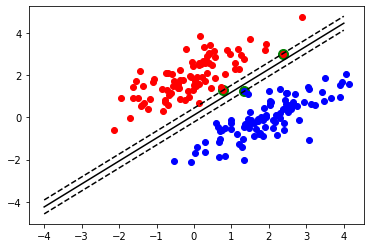

     pcost       dcost       gap    pres   dres
 0: -6.0272e+01 -1.6762e+02  5e+02  2e+01  2e+00
 1: -9.3558e+01 -2.0773e+02  2e+02  7e+00  7e-01
 2: -1.1700e+02 -2.3495e+02  2e+02  6e+00  6e-01
 3: -1.4234e+02 -2.2174e+02  1e+02  3e+00  3e-01
 4: -1.6211e+02 -2.4395e+02  1e+02  2e+00  2e-01
 5: -1.9581e+02 -2.3606e+02  5e+01  1e+00  9e-02
 6: -2.0836e+02 -2.2587e+02  2e+01  4e-14  3e-14
 7: -2.1952e+02 -2.2280e+02  3e+00  4e-14  3e-14
 8: -2.2210e+02 -2.2219e+02  9e-02  9e-14  4e-14
 9: -2.2218e+02 -2.2218e+02  9e-04  3e-14  3e-14
10: -2.2218e+02 -2.2218e+02  9e-06  4e-14  3e-14
Optimal solution found.
10 support vectors out of 180 points


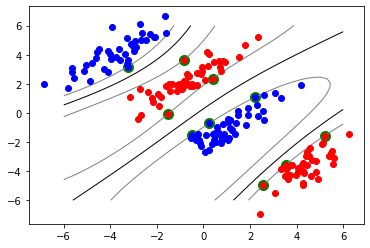

In [23]:
if __name__ == "__main__":
    import matplotlib.pyplot as pl
    
    def gen_lin_separable_data():
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[0.8, 0.6], [0.6, 0.8]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2
    
    def gen_non_lin_separable_data():
        mean1 = [-1, 2]
        mean2 = [1, -1]
        mean3 = [4, -4]
        mean4 = [-4, 4]
        cov = [[1.0,0.8], [0.8, 1.0]]
        X1 = np.random.multivariate_normal(mean1, cov, 50)
        X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 50)
        X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2
    
    def gen_lin_separable_overlap_data():
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[1.5, 1.0], [1.0, 1.5]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2
    
    def split_train(X1, y1, X2, y2):
        X1_train = X1[:90]
        y1_train = y1[:90]
        X2_train = X2[:90]
        y2_train = y2[:90]
        X_train = np.vstack((X1_train, X2_train))
        y_train = np.hstack((y1_train, y2_train))
        return X_train, y_train
    
    def split_test(X1, y1, X2, y2):
        X1_test = X1[90:]
        y1_test = y1[90:]
        X2_test = X2[90:]
        y2_test = y2[90:]
        X_test = np.vstack((X1_test, X2_test))
        y_test = np.hstack((y1_test, y2_test))
        return X_test, y_test
    
    def plot_margin(X1_train, X2_train, clf):
        
        def f(x, w, b, c=0):
            return (-w[0] * x - b + c) / w[1]
        
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")
        
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")
        
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")
        
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")
        
        pl.axis("tight")
        pl.show()
    
    def plot_contour(X1_train, X2_train, clf):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")
        
        X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
        
        pl.axis("tight")
        pl.show()
    
    def test_linear():
        X1, y1, X2, y2 = gen_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)
        
        clf = SVM()
        clf.fit(X_train, y_train)
        
        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print('{0} out of {1} predictions correct'.format(correct, len(y_predict)))
        
        plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)
    
              
    def test_non_linear():
        X1, y1, X2, y2 = gen_non_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)
        
        clf = SVM(gaussian_kernel)
        clf.fit(X_train, y_train)
        
        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print('{0} out of {1} predictions correct'.format(correct, len(y_predict)))
        
        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)
    
    def test_soft():
        X1, y1, X2, y2 = gen_lin_separable_overlap_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)
        
        clf = SVM(C=0.1)
        clf.fit(X_train, y_train)
        
        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print('{0} out of {1} predictions correct'.format(correct, len(y_predict)))
        
        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)
    
    test_soft()
    test_linear()
    test_non_linear()